In [35]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [51]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
loss_func = RMSELoss()

In [52]:
user,item,title = 'userId','movieId','title'

In [53]:
path = untar_data(URLs.ML_SAMPLE)

In [54]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [56]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [57]:
y_range = [0,5.5]

In [58]:
learn = collab_learner(data, n_factors=50, y_range=y_range, loss_func=loss_func)

In [59]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.248441,0.935032,00:00
1,0.892021,0.814210,00:00
2,0.799355,0.812664,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [60]:
path=Config.data_path()/'ml-100k'

In [61]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [62]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [63]:
len(ratings)

100000

In [64]:
title

'title'

In [65]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [66]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [67]:
data.show_batch()

userId,title,target
617,"Piano, The (1993)",4.0
387,Sneakers (1992),1.0
347,Old Yeller (1957),3.0
748,Indiana Jones and the Last Crusade (1989),3.0
276,Ace Ventura: When Nature Calls (1995),3.0


In [68]:
#the sigmoind function assymptotes the outputs so it will never be the extremes.
#that is why it is interesting to give some room for the limits
y_range = [0,5.5]

In [71]:
#factors could be the lenght of the embedding size
#width of the emb matrix - related to latent factors
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1, loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


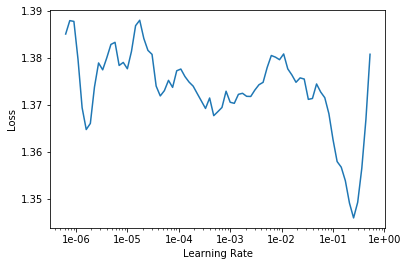

In [72]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [73]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.970019,0.966355,00:05
1,0.910882,0.933980,00:05
2,0.868859,0.908426,00:05
3,0.811045,0.897378,00:05
4,0.735966,0.896620,00:05


In [76]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [77]:
learn.load('dotprod');

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RMSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [78]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [79]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [80]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [81]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [82]:
item0 = lambda o:o[0]

In [83]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3660),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3196),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2782), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2762), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2635), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2583), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2399), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2338), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2266), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2206), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2188), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2119), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2088), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2050), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2046), 'Showgirls (1995)', 1.

In [84]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6066), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5668), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5637), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5404), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5392), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5220), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5181), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5081), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4950), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4930), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4897), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4830), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4770), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4751), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4572), 'Wrong Trousers, The (1993)', 4.466101694915254)]

### Movie weights

In [85]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [86]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [87]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [88]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1107), 'Casablanca (1942)'),
 (tensor(1.0913), 'Wrong Trousers, The (1993)'),
 (tensor(1.0790), 'Lawrence of Arabia (1962)'),
 (tensor(1.0116), 'Close Shave, A (1995)'),
 (tensor(1.0021), 'Chinatown (1974)'),
 (tensor(0.9895), 'Godfather, The (1972)'),
 (tensor(0.9537), 'Persuasion (1995)'),
 (tensor(0.9489), 'Third Man, The (1949)'),
 (tensor(0.9466), 'Citizen Kane (1941)'),
 (tensor(0.9259), 'When We Were Kings (1996)')]

In [89]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3633), 'Home Alone 3 (1997)'),
 (tensor(-1.2153), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1820), 'Jungle2Jungle (1997)'),
 (tensor(-1.1640), "McHale's Navy (1997)"),
 (tensor(-1.1625), 'Bio-Dome (1996)'),
 (tensor(-1.1329), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0812), 'Batman & Robin (1997)'),
 (tensor(-1.0748), 'Flipper (1996)'),
 (tensor(-1.0537), 'Leave It to Beaver (1997)'),
 (tensor(-1.0435), 'Free Willy 3: The Rescue (1997)')]

In [90]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [91]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8987), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8406), 'Trainspotting (1996)'),
 (tensor(0.8039), 'Brazil (1985)'),
 (tensor(0.7962), 'Keys to Tulsa (1997)'),
 (tensor(0.7799), 'Clockwork Orange, A (1971)'),
 (tensor(0.7671), 'Cable Guy, The (1996)'),
 (tensor(0.7634), 'Dead Man (1995)'),
 (tensor(0.7473), 'Spice World (1997)'),
 (tensor(0.7452), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7266), 'Lost Highway (1997)')]

In [92]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1841), 'Braveheart (1995)'),
 (tensor(-1.1153), 'Titanic (1997)'),
 (tensor(-0.9956), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.8951), "It's a Wonderful Life (1946)"),
 (tensor(-0.8787), 'Pretty Woman (1990)'),
 (tensor(-0.8661), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8653), 'Forrest Gump (1994)'),
 (tensor(-0.8571), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8492), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8485), 'American President, The (1995)')]

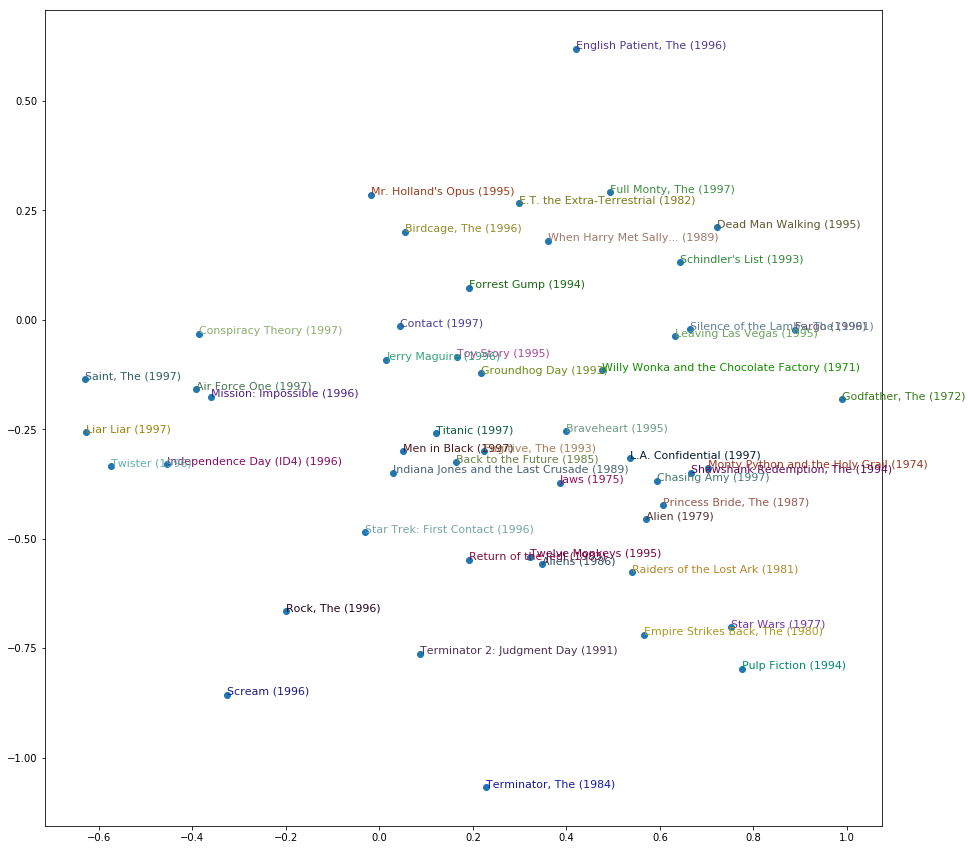

In [93]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()